In [1]:
import re

# Read in the text file (assuming it's cleaned up and saved locally)
with open('wiki.txt', 'r', encoding='utf-8') as file:
    content = file.read()

# Regular expression to match all links
links = re.findall(r'\[\[(.*?)\]\]', content)

# Clean up and process links (handle pipes for display text)
artists = []
for link in links:
    # If there's a pipe, the first part is the link, the second part is the display text
    if '|' in link:
        artists.append(link.split('|')[0])
    else:
        artists.append(link)

print(f'Total number of artists: {len(artists)}')


Total number of artists: 2100


In [2]:
import requests
import os

# Base URL for Wikipedia API
BASE_API_URL = "https://en.wikipedia.org/w/api.php"

# Directory to save text files
SAVE_DIR = "country_artists_wiki"

# Ensure the directory exists
os.makedirs(SAVE_DIR, exist_ok=True)

def fetch_wikitext(page_title):
    """Fetch the wikitext of a Wikipedia page."""
    params = {
        "action": "query",
        "format": "json",
        "titles": page_title,
        "prop": "revisions",
        "rvprop": "content",
        "formatversion": "2",
    }
    response = requests.get(BASE_API_URL, params=params)
    data = response.json()
    pages = data.get("query", {}).get("pages", [])
    
    if pages and "revisions" in pages[0]:
        return pages[0]["revisions"][0]["content"]
    return None

def save_wikitext(artist, wikitext):
    """Save the wikitext to a file."""
    # Replace spaces and invalid characters with underscores for file names
    safe_artist = re.sub(r'[\\/*?:"<>|]', "_", artist)
    filename = os.path.join(SAVE_DIR, f"{safe_artist.replace(' ', '_')}.txt")
    with open(filename, "w", encoding="utf-8") as file:
        file.write(wikitext)

# Iterate through the list of artists and download their Wikipedia page wikitext
for artist in artists:
    wikitext = fetch_wikitext(artist)
    
    if wikitext:
        save_wikitext(artist, wikitext)
    else:
        print(f"Wikitext for {artist} not found or page is missing.")

print("Done fetching all wikitexts.")

Done fetching all wikitexts.


In [3]:
import os
import re
import networkx as nx

# Directory containing Wikipedia pages
SAVE_DIR = "country_artists_wiki"

# Sample list of performers (This should be replaced with the complete list)
performers = [file.replace('_', ' ').replace('.txt', '') for file in os.listdir(SAVE_DIR) if file.endswith('.txt')]

# Initialize the directed graph
G = nx.DiGraph()

# Helper function to count words in the page content
def count_words(content):
    words = re.findall(r'\b\w+\b', content)
    return len(words)

# Function to extract valid links pointing to other performers
def extract_links(wikitext, performers):
    # Regular expression to find all Wikipedia links
    links = re.findall(r'\[\[(.*?)(?:\|(.*?))?\]\]', wikitext)
    valid_links = []
    
    for link, display_text in links:
        # Clean the link, replace underscores with spaces, and match against performers
        clean_link = link.replace('_', ' ').strip()
        if clean_link in performers:
            valid_links.append(clean_link)
    
    return valid_links

# Process all performer pages in the directory
for performer_file in os.listdir(SAVE_DIR):
    if performer_file.endswith('.txt'):
        performer_name = performer_file.replace('_', ' ').replace('.txt', '')
        
        # Open and read the wikitext for this performer
        with open(os.path.join(SAVE_DIR, performer_file), 'r', encoding='utf-8') as f:
            wikitext = f.read()
        
        # Extract links to other performers
        linked_performers = extract_links(wikitext, performers)
        
        # Count the number of words in the page content
        word_count = count_words(wikitext)
        
        # Add the node to the graph with the word count as an attribute
        G.add_node(performer_name, word_count=word_count)
        
        # Add directed edges from this performer to the performers they link to
        for linked_performer in linked_performers:
            G.add_edge(performer_name, linked_performer)

# Output the total number of nodes and edges
print(f"Total performers (nodes): {G.number_of_nodes()}")
print(f"Total links (edges): {G.number_of_edges()}")

Total performers (nodes): 2098
Total links (edges): 17670


In [4]:
# Remove disconnected nodes
disconnected_nodes = [node for node in G.nodes if G.degree(node) == 0]
print(f"Removing {len(disconnected_nodes)} disconnected nodes.")
G.remove_nodes_from(disconnected_nodes)


Removing 146 disconnected nodes.


In [8]:
# Extract the largest connected component
largest_component = max(nx.weakly_connected_components(G), key=len)
G_largest = G.subgraph(largest_component).copy()

# Print some information about the graph
print(f"Number of nodes: {G_largest.number_of_nodes()}")
print(f"Number of edges: {G_largest.number_of_edges()}")

Number of nodes: 1944
Number of edges: 17663


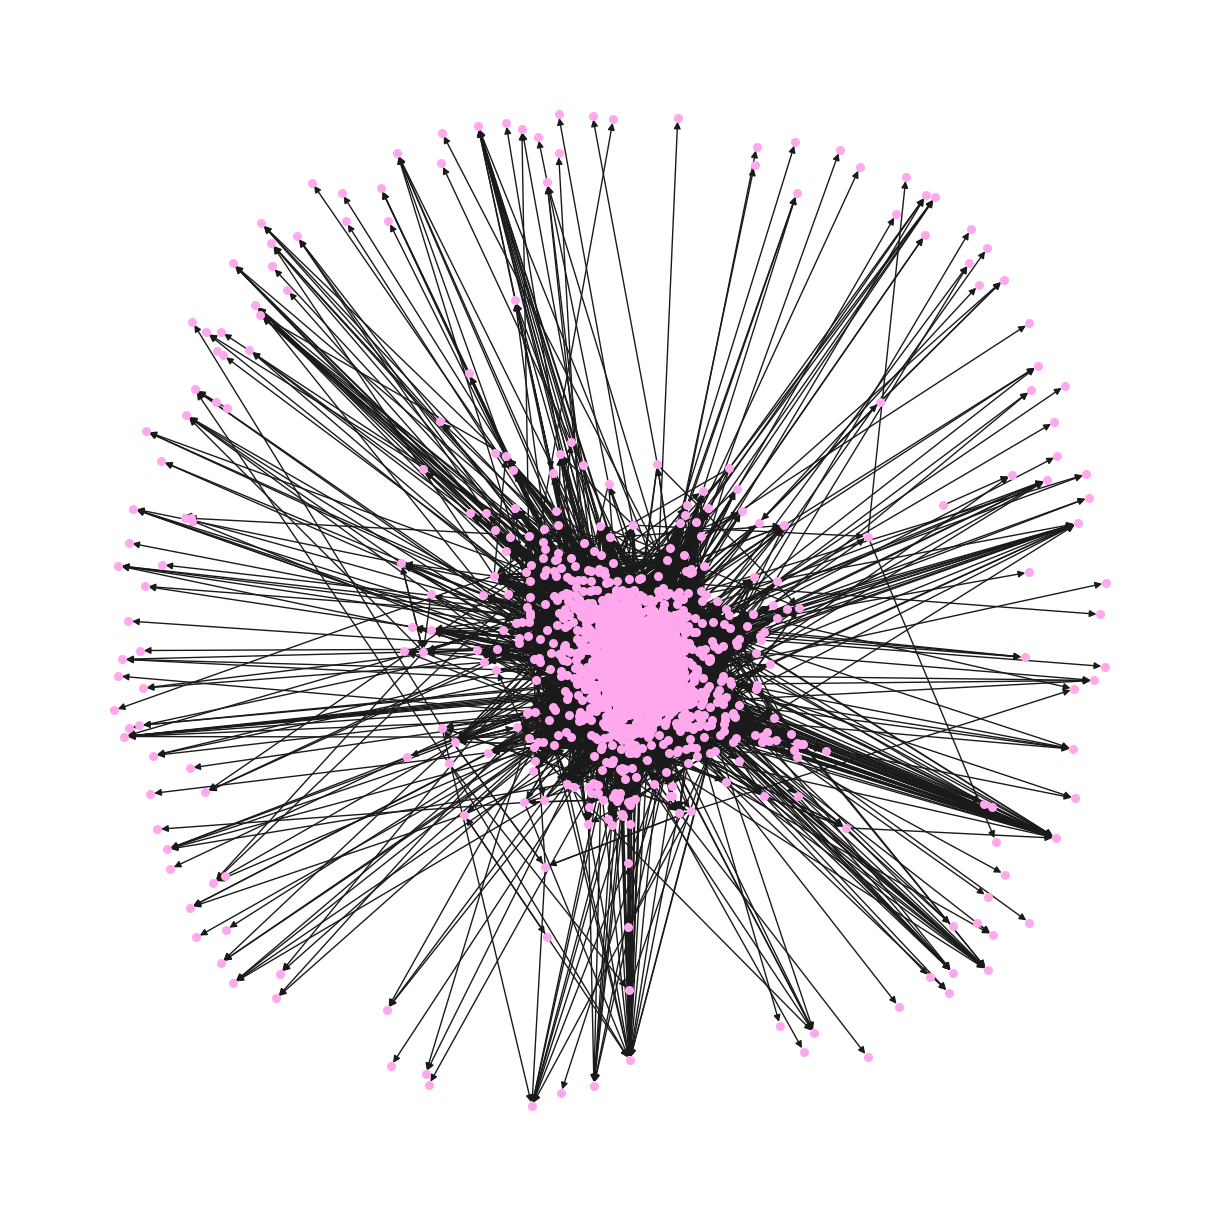

In [17]:
import matplotlib.pyplot as plt
# Plot the network     
pos = nx.spring_layout(G_largest)
plt.figure(1,figsize=(12,12))
nx.draw(G_largest, node_size=30, node_color="#FFA8EE", node_shape='o', edge_color='.1', with_labels=False, width=1, pos=pos)
plt.show()

# Visualize the largest component
# plt.figure(figsize=(12, 12))
# pos = nx.spring_layout(G_largest)
# nx.draw(G_largest, pos, with_labels=True, node_size=50, font_size=8)
# plt.show()

In [9]:
num_nodes = G.number_of_nodes()
num_links = G.number_of_edges()

print(f"Number of nodes: {num_nodes}")
print(f"Number of links: {num_links}")

Number of nodes: 1952
Number of links: 17670


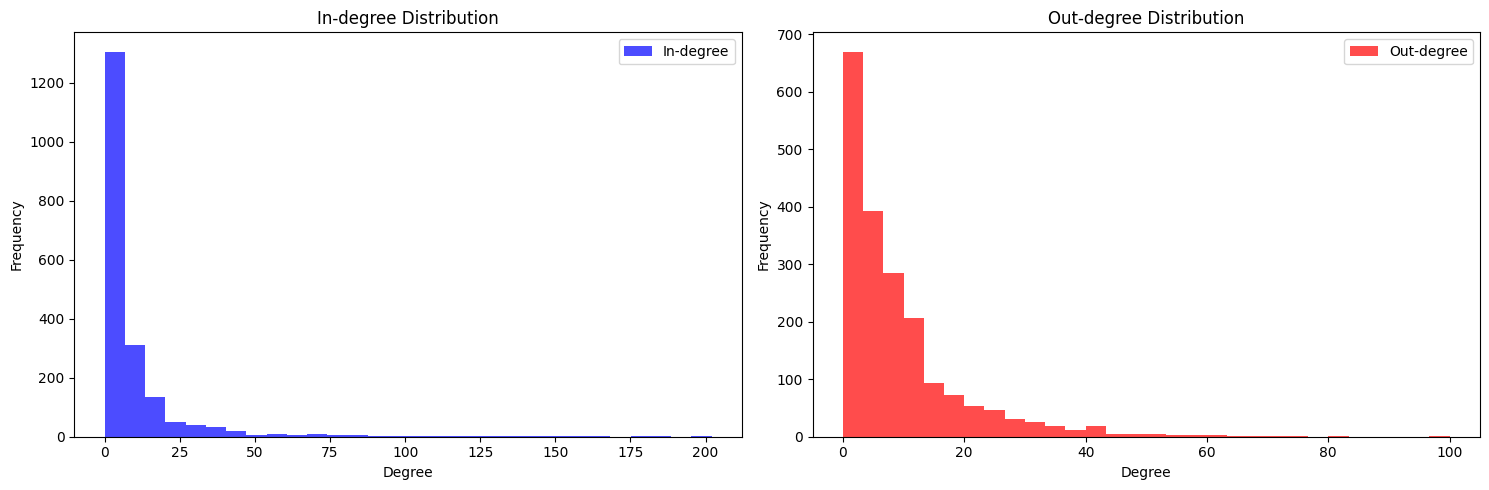

In [10]:
import matplotlib.pyplot as plt

# Get the in-degree and out-degree for each node
in_degrees = [d for n, d in G.in_degree()]
out_degrees = [d for n, d in G.out_degree()]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot the in-degree distribution as a histogram in the first subplot
ax1.hist(in_degrees, bins=30, color='blue', alpha=0.7, label='In-degree')
ax1.set_title("In-degree Distribution")
ax1.set_xlabel("Degree")
ax1.set_ylabel("Frequency")
ax1.legend()

# Plot the out-degree distribution as a histogram in the second subplot
ax2.hist(out_degrees, bins=30, color='red', alpha=0.7, label='Out-degree')
ax2.set_title("Out-degree Distribution")
ax2.set_xlabel("Degree")
ax2.set_ylabel("Frequency")
ax2.legend()

# Adjust layout
plt.tight_layout()
plt.show()

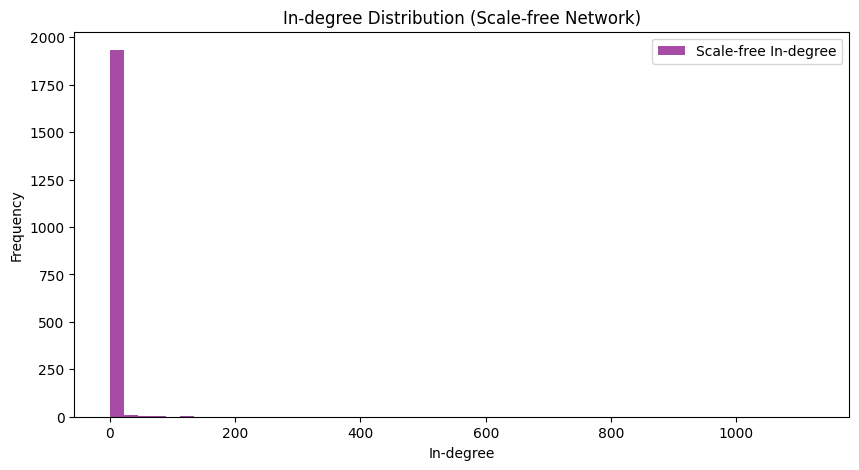

In [11]:
import networkx as nx

# Generate a scale-free network with the same number of nodes
scale_free_net = nx.scale_free_graph(num_nodes, seed=42)

# Get the in-degrees for the scale-free network
scale_free_in_degrees = [d for n, d in scale_free_net.in_degree()]

# Plot the in-degree distribution of the scale-free network
plt.figure(figsize=(10, 5))
plt.hist(scale_free_in_degrees, bins=50, color='purple', alpha=0.7, label='Scale-free In-degree')
plt.title("In-degree Distribution (Scale-free Network)")
plt.xlabel("In-degree")
plt.ylabel("Frequency")
plt.legend()
plt.show()

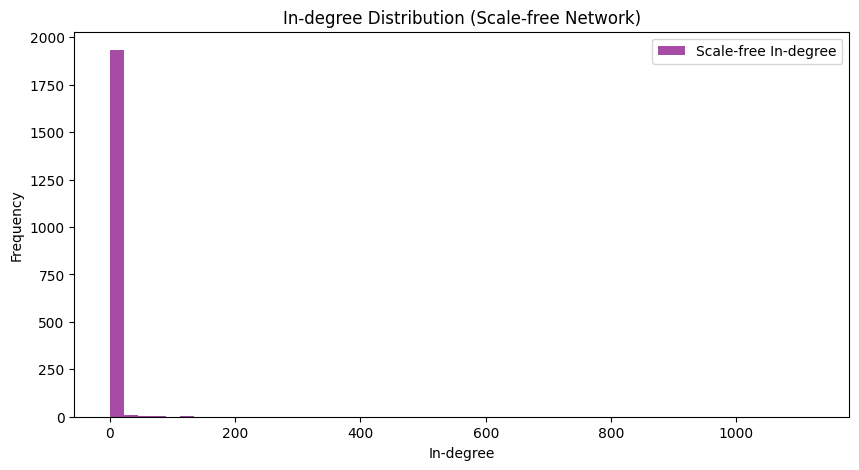

In [12]:
from networkx import scale_free_graph

# Generate a scale-free network with the same number of nodes
scale_free_net = scale_free_graph(num_nodes, seed=42)

# Get the in-degrees for the scale-free network
scale_free_in_degrees = [d for n, d in scale_free_net.in_degree()]

# Plot the in-degree distribution of the scale-free network
plt.figure(figsize=(10, 5))
plt.hist(scale_free_in_degrees, bins=50, color='purple', alpha=0.7, label='Scale-free In-degree')
plt.title("In-degree Distribution (Scale-free Network)")
plt.xlabel("In-degree")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [13]:
# Top 5 performers by in-degree
top_in_degree = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 Performers by In-degree:", top_in_degree)

# Top 5 performers by out-degree
top_out_degree = sorted(G.out_degree(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 Performers by Out-degree:", top_out_degree)


Top 5 Performers by In-degree: [('Willie Nelson', 202), ('Johnny Cash', 184), ('Elvis Presley', 177), ('Dolly Parton', 162), ('Merle Haggard', 157)]
Top 5 Performers by Out-degree: [('Hillary Lindsey', 100), ('Pam Tillis', 82), ('Randy Travis', 75), ('Vince Gill', 71), ('Patty Loveless', 68)]


In [14]:
# Sort nodes by the 'word_count' attribute
top_by_word_count = sorted(G.nodes(data=True), key=lambda x: x[1]['word_count'], reverse=True)[:10]

print("Top 10 Performers by Wikipedia Page Length:")
for performer, attr in top_by_word_count:
    print(f"{performer}: {attr['word_count']} words")


Top 10 Performers by Wikipedia Page Length:
Beyoncé: 62853 words
Taylor Swift: 56355 words
Miley Cyrus: 51262 words
Justin Bieber: 50694 words
Carrie Underwood: 45243 words
Justin Timberlake: 44779 words
Demi Lovato: 44077 words
Bob Dylan: 41141 words
Ed Sheeran: 36312 words
Elvis Presley: 33793 words


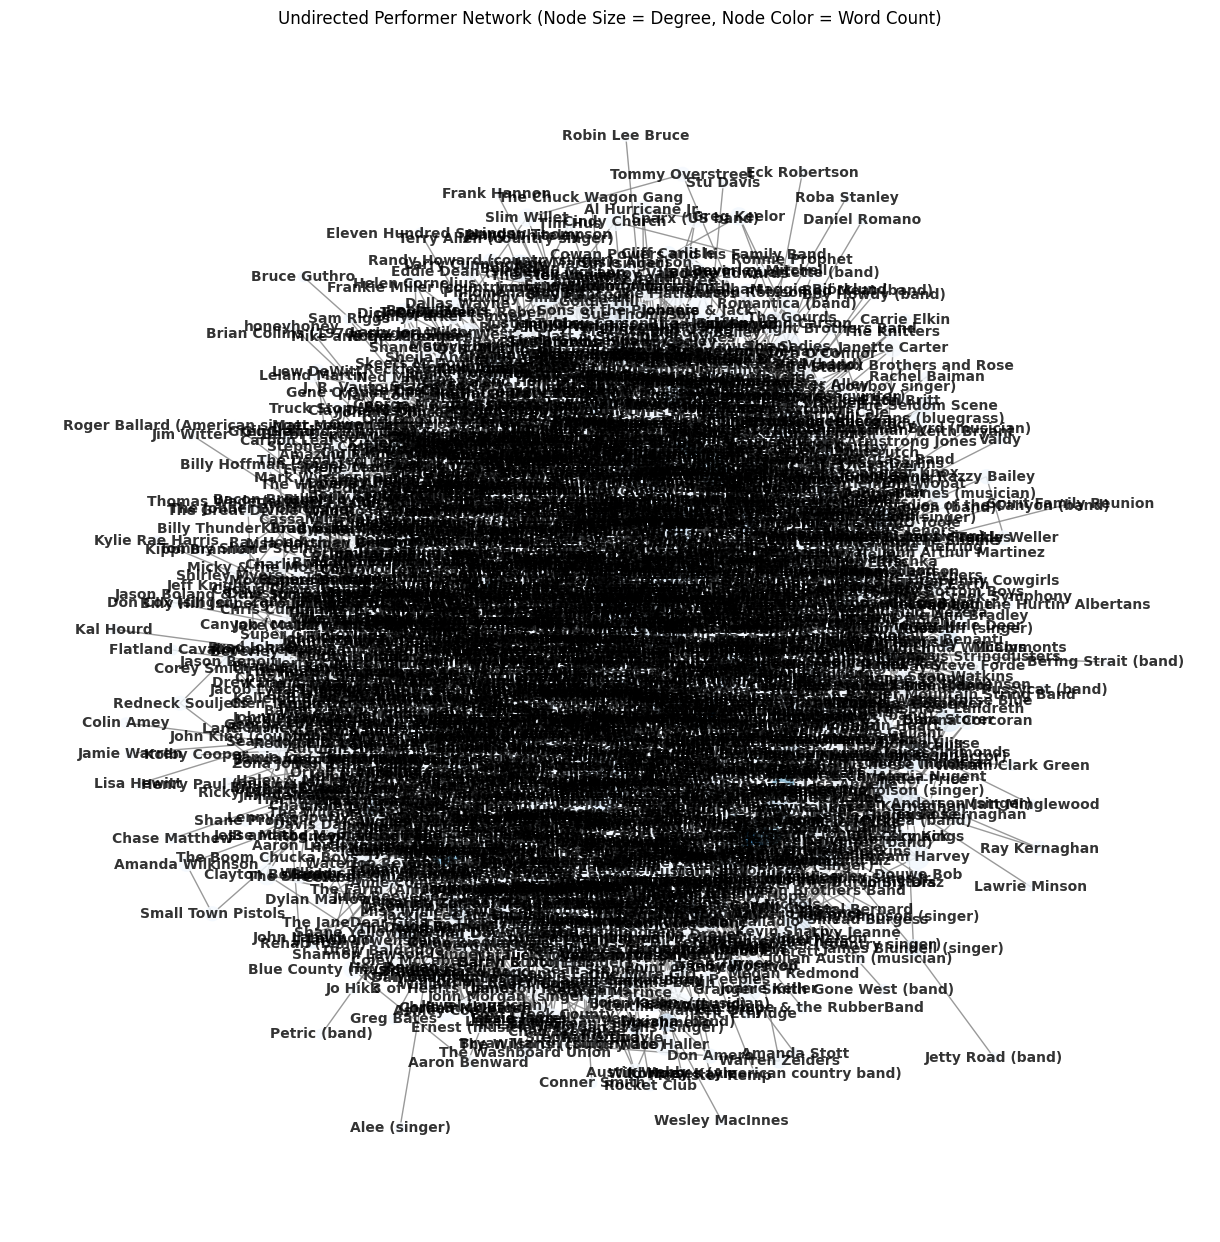

In [16]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Convert the directed graph to an undirected graph
G_undirected = G.to_undirected()

# Get the node degrees (for determining node size)
node_sizes = [G_undirected.degree(node) * 50 for node in G_undirected.nodes()]

# Get the word counts for each node to determine color intensity
node_colors = [G.nodes[node]['word_count'] for node in G_undirected.nodes()]

# Normalize the colors (word counts) for colormap
norm = plt.Normalize(min(node_colors), max(node_colors))

# Draw the undirected graph using the Kamada-Kawai layout
plt.figure(figsize=(12, 12))
pos = nx.kamada_kawai_layout(G_undirected)

# Draw the graph
nx.draw(
    G_undirected,
    pos,
    with_labels=True,
    node_size=node_sizes,
    node_color=node_colors,
    cmap='Blues',  # Use a simple sequential colormap
    edge_color='gray',
    font_size=10,
    font_weight='bold',
    alpha=0.8
)

# Add a color bar
#sm = plt.cm.ScalarMappable(cmap='Blues', norm=norm)
#sm.set_array([])
#plt.colorbar(sm, label='Word Count')

# Show the plot
plt.title("Undirected Performer Network (Node Size = Degree, Node Color = Word Count)")
plt.show()